# Imports and Dataset manipulation

In [ ]:
! pip install keras_tuner

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 133 kB 7.4 MB/s 


In [ ]:
! pip install pyyaml h5py

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import random
import tensorflow as tf
import keras
from tensorflow import keras
from keras.layers import Dense, Conv2D, Activation, MaxPool2D, Flatten, Dropout, BatchNormalization
import keras_tuner as kt
from keras.datasets import fashion_mnist
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
(train_X, train_y), (test_X, test_y) = fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [ ]:
train_X.shape

(60000, 28, 28)

In [ ]:
train_images  = train_X / 255.0
test_images = test_X / 255.0

In [ ]:
np.unique(train_y, return_counts = True) #The dataframe is balanced at 6000 items per class

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]))

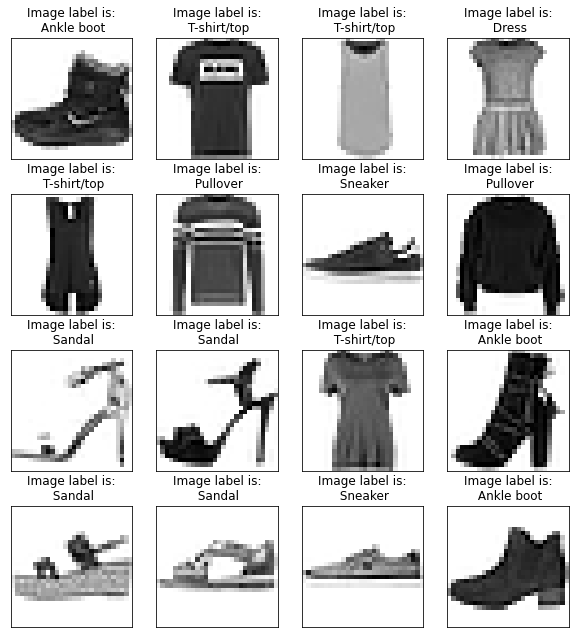

In [ ]:
label = {0:"T-shirt/top",
1 :"Trouser",
2 :"Pullover",
3 :"Dress",
4 :"Coat",
5 :"Sandal",
6 :"Shirt",
7 :"Sneaker",
8 :"Bag",
9 :"Ankle boot"}

plt.figure(figsize=(10,11))
for i in range(16):
    plt.subplot(4,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.title("Image label is:\n {}".format(label[train_y[i]]))
plt.show()

In [ ]:
x_train=train_images.reshape(-1,28,28,1)
x_test=test_images.reshape(-1,28,28,1)

In [ ]:
def veczer(d):
  matrix = np.eye(10)
  vec = matrix[d]
  return vec

In [ ]:
test_y_vec = np.array([veczer(y) for y in test_y])
train_y_vec = np.array([veczer(y) for y in train_y])

In [ ]:
train_y_vec.shape

(60000, 10)

# MLP

In [ ]:
def build_model(hp):
  """
  Builds model and sets up hyperparameter space to search.
 
  Parameters
  ----------
  hp : HyperParameter object
      Configures hyperparameters to tune.
      
  Returns
 -------
  model : keras model
      Compiled model with hyperparameters to tune.
  """
  # Initialize sequential API and start building model.
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28,1)))
  
  # Tune the number of hidden layers and units in each.
  # Number of hidden layers: 4 - 5
  # Number of Units: 32 - 512 with stepsize of 32
  for i in range(1, hp.Int("num_layers", 4, 5)):
      model.add(
          keras.layers.Dense(
              units=hp.Int("units_" + str(i), min_value=32, max_value=512, step=32),
              activation="gelu")
          )
      
     # Tune dropout layer with values from 0 - 0.5 with stepsize of 0.3.
      model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0., 0.3, step=0.1)))
  
  # Add output layer.
  model.add(keras.layers.Dense(units=10, activation= "softmax"))
  
  # Tune learning rate for Adam optimizer with values from  0.001, 0.004 or 0.0001
  hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4,1e-5])
  
  # Define optimizer, loss, and metrics
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
  
  return model

In [ ]:
# Instantiate the tuner
tuner = kt.BayesianOptimization(build_model,
                     #Metric which will be used for the hyperparameter tuning
                     objective="val_accuracy",
                     max_trials=6,directory="my_dir",project_name="MLP",overwrite=True)

In [ ]:
tuner.search_space_summary(extended=True)

Search space summary
Default search space size: 8
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 4, 'max_value': 5, 'step': 1, 'sampling': None}
units_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_1 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_2 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
units_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_3 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.3, 'step': 0.1, 'sampling': None}
learning_rate (Choice)
{'default': 0.001, 'conditions': [], 'values': [0.001, 0.0001, 1e-05], 'ordered': True}


In [ ]:
NUM_EPOCHS=100

In [ ]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)



In [ ]:
#Tuning
tuner.search(x_train, train_y_vec, epochs=NUM_EPOCHS, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner.get_best_hyperparameters()[0]

# Build model
h_model = tuner.hypermodel.build(best_hps)

# Train the hypertuned model
history = h_model.fit(x_train, train_y_vec, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)

In [ ]:
def build_model():

  # Initialize sequential API and start building model.
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28,28,1)))
  model.add(keras.layers.Dense(448,activation="gelu"))
  model.add(keras.layers.Dropout(0.3))
  model.add(keras.layers.Dense(32,activation="gelu"))
  model.add(keras.layers.Dense(32,activation="gelu"))
  model.add(keras.layers.Dense(32,activation="gelu"))
  
  # Add output layer.
  model.add(keras.layers.Dense(units=10, activation= "softmax"))
  
  # Define optimizer, loss, and metrics
  model.compile(optimizer=keras.optimizers.Adam(learning_rate= 1e-4),
                loss=keras.losses.CategoricalCrossentropy(),
                metrics=["accuracy"])
  
  return model

In [ ]:
h_model=build_model()

In [ ]:
#Checking model summary
h_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 448)               351680    
                                                                 
 dropout (Dropout)           (None, 448)               0         
                                                                 
 dense_1 (Dense)             (None, 32)                14368     
                                                                 
 dense_2 (Dense)             (None, 32)                1056      
                                                                 
 dense_3 (Dense)             (None, 32)                1056      
                                                                 
 dense_4 (Dense)             (None, 10)                3

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)
# Train the hypertuned model
history = h_model.fit(x_train, train_y_vec, epochs=100, validation_split=0.2, callbacks=[stop_early], verbose=2)

Epoch 1/100
1500/1500 - 9s - loss: 0.7655 - accuracy: 0.7444 - val_loss: 0.4980 - val_accuracy: 0.8281 - 9s/epoch - 6ms/step
Epoch 2/100
1500/1500 - 6s - loss: 0.4841 - accuracy: 0.8308 - val_loss: 0.4443 - val_accuracy: 0.8420 - 6s/epoch - 4ms/step
Epoch 3/100
1500/1500 - 6s - loss: 0.4286 - accuracy: 0.8479 - val_loss: 0.4007 - val_accuracy: 0.8601 - 6s/epoch - 4ms/step
Epoch 4/100
1500/1500 - 6s - loss: 0.3956 - accuracy: 0.8586 - val_loss: 0.3846 - val_accuracy: 0.8665 - 6s/epoch - 4ms/step
Epoch 5/100
1500/1500 - 6s - loss: 0.3742 - accuracy: 0.8654 - val_loss: 0.3676 - val_accuracy: 0.8691 - 6s/epoch - 4ms/step
Epoch 6/100
1500/1500 - 6s - loss: 0.3550 - accuracy: 0.8727 - val_loss: 0.3510 - val_accuracy: 0.8752 - 6s/epoch - 4ms/step
Epoch 7/100
1500/1500 - 6s - loss: 0.3400 - accuracy: 0.8774 - val_loss: 0.3551 - val_accuracy: 0.8723 - 6s/epoch - 4ms/step
Epoch 8/100
1500/1500 - 6s - loss: 0.3256 - accuracy: 0.8817 - val_loss: 0.3386 - val_accuracy: 0.8786 - 6s/epoch - 4ms/step


In [ ]:
print(f"""The number of layers is {best_hps.get("num_layers")-1}""")
print(f"""The number of nodes in layer 1 is {best_hps.get("units_1")}""")
print(f"""The number of nodes in layer 2 is {best_hps.get("units_2")}""")
print(f"""The number of nodes in layer 3 is {best_hps.get("units_3")}""")
print(f"""The number of nodes in layer 4 is {best_hps.get("units_4")}""")
print("-------------------------------------------------")
print(f"""learning_rate is {best_hps.get('learning_rate')}""")
print(f"""The dropout probability after the 1st layer is {round(best_hps.get('dropout_1'),2)}""")
print(f"""The dropout probability after the 2nd layer is {best_hps.get('dropout_2')}""")
print(f"""The dropout probability after the 3rd layer is {best_hps.get('dropout_3')}""")
print(f"""The dropout probability after the 4th layer is {best_hps.get('dropout_4')}""")

In [ ]:
#h_model.save('/content/drive/MyDrive/deep_MLP')

In [ ]:
#h_model=tf.keras.models.load_model('/content/drive/MyDrive/deep_MLP')

In [ ]:
predictions_test = h_model.predict(x_test)
prediction_test=[]
for i in range(len(predictions_test)):
  prediction_test.append(np.argmax(predictions_test[i]))

In [ ]:
#Calculating Accuracy score
score = accuracy_score(test_y, prediction_test)

print("Test accuracy-score: {:.2f}% \n".format(score*100))

Test accuracy-score: 89.50% 



In [ ]:
eval_result = h_model.evaluate(x_test, test_y_vec)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.3149 - accuracy: 0.8950
[test loss, test accuracy]: [0.31487733125686646, 0.8949999809265137]


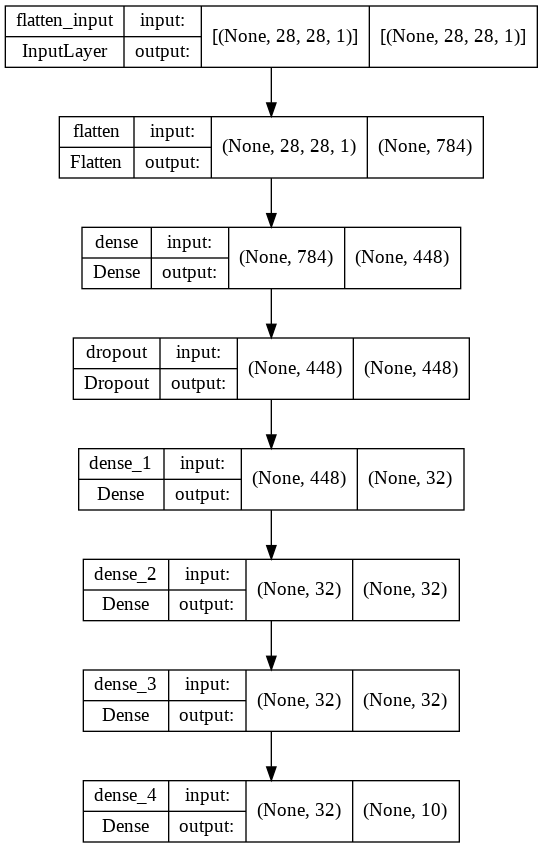

In [ ]:
keras.utils.plot_model(h_model, show_shapes=True)

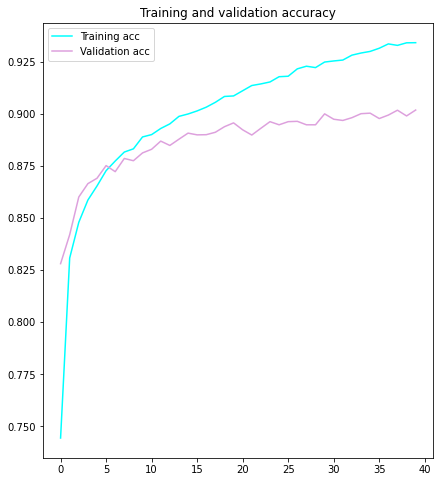

<Figure size 432x288 with 0 Axes>

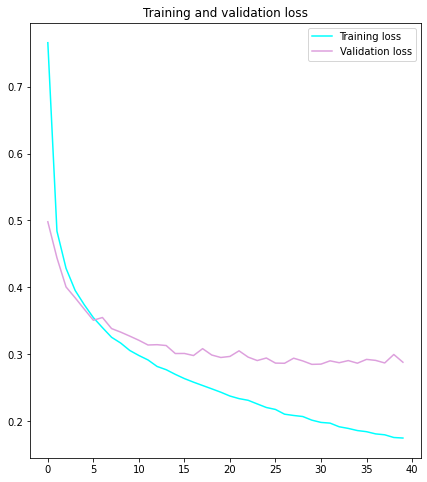

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss'] 

epochs = range(len(acc))

plt.figure(figsize = (7,8))

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'plum', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
mat = confusion_matrix(test_y, prediction_test)

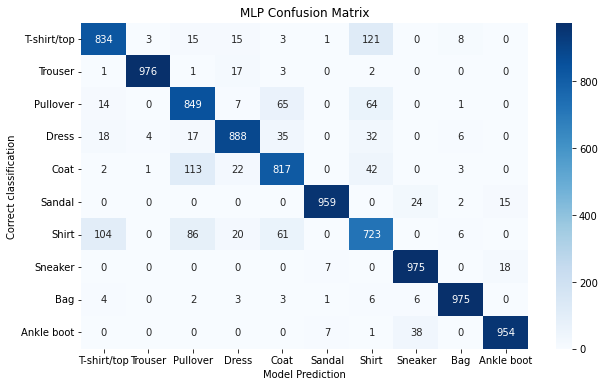

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Confusion Matrix')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
mat_perc = 100*(mat / mat.sum(axis=1))

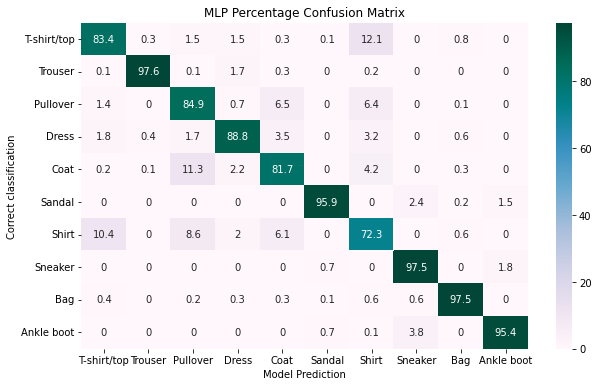

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Percentage Confusion Matrix')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_y, prediction_test))

              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1000
           1       0.99      0.98      0.98      1000
           2       0.78      0.85      0.82      1000
           3       0.91      0.89      0.90      1000
           4       0.83      0.82      0.82      1000
           5       0.98      0.96      0.97      1000
           6       0.73      0.72      0.73      1000
           7       0.93      0.97      0.95      1000
           8       0.97      0.97      0.97      1000
           9       0.97      0.95      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.89      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
def data_augm(train_x, train_y,):
    
  # Instantiate the ImageDataGenerator class and also we need to normalize pixel values and set arguments to augment the images (if desired)
    train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


  
    train_generator = train_datagen.flow(x=train_x,
                                       y=train_y,
                                       batch_size=32) 

    return train_generator

In [ ]:
k=data_augm(x_train[np.logical_or(train_y==6 , train_y==2)],train_y[np.logical_or(train_y==6 , train_y==2)])

In [ ]:
augmented_data_x = np.concatenate((x_train, k.x))
augmented_data_y = np.concatenate((train_y, k.y))

In [ ]:
augmented_data_y = veczer(augmented_data_y)

In [ ]:
#Reinitializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=15)

In [ ]:
h_model_aug = build_model()
history_aug = h_model_aug.fit(augmented_data_x, augmented_data_y, epochs=100, validation_split=0.25, callbacks=[stop_early], verbose=2)

Epoch 1/100
1688/1688 - 8s - loss: 0.7448 - accuracy: 0.7524 - val_loss: 0.8270 - val_accuracy: 0.6782 - 8s/epoch - 5ms/step
Epoch 2/100
1688/1688 - 7s - loss: 0.4761 - accuracy: 0.8328 - val_loss: 0.6689 - val_accuracy: 0.7452 - 7s/epoch - 4ms/step
Epoch 3/100
1688/1688 - 7s - loss: 0.4215 - accuracy: 0.8495 - val_loss: 0.6520 - val_accuracy: 0.7423 - 7s/epoch - 4ms/step
Epoch 4/100
1688/1688 - 7s - loss: 0.3882 - accuracy: 0.8603 - val_loss: 0.6337 - val_accuracy: 0.7437 - 7s/epoch - 4ms/step
Epoch 5/100
1688/1688 - 7s - loss: 0.3649 - accuracy: 0.8691 - val_loss: 0.6620 - val_accuracy: 0.7346 - 7s/epoch - 4ms/step
Epoch 6/100
1688/1688 - 7s - loss: 0.3472 - accuracy: 0.8740 - val_loss: 0.5343 - val_accuracy: 0.7941 - 7s/epoch - 4ms/step
Epoch 7/100
1688/1688 - 7s - loss: 0.3330 - accuracy: 0.8779 - val_loss: 0.5370 - val_accuracy: 0.7861 - 7s/epoch - 4ms/step
Epoch 8/100
1688/1688 - 9s - loss: 0.3200 - accuracy: 0.8835 - val_loss: 0.5579 - val_accuracy: 0.7799 - 9s/epoch - 5ms/step


In [ ]:
predictions_test_aug = h_model_aug.predict(x_test)
prediction_test_aug=[]
for i in range(len(predictions_test)):
  prediction_test_aug.append(np.argmax(predictions_test_aug[i]))

In [ ]:
#Calculating Accuracy score
score = accuracy_score(test_y, prediction_test_aug)

print("Test accuracy-score: {:.2f}% \n".format(score*100))

Test accuracy-score: 90.22% 



In [ ]:
eval_result = h_model_aug.evaluate(x_test, test_y_vec)
print("[test loss, test accuracy]:", eval_result)

313/313 [==============================] - 1s 3ms/step - loss: 0.3998 - accuracy: 0.9022
[test loss, test accuracy]: [0.3998491168022156, 0.9021999835968018]


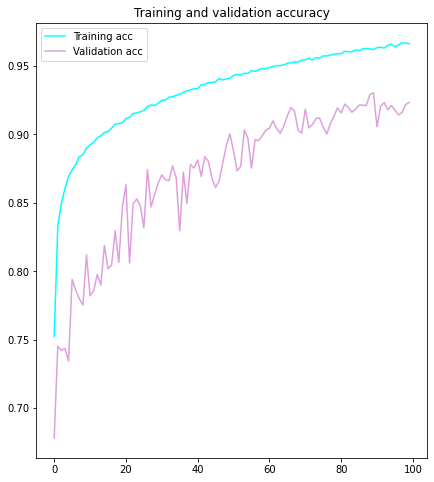

<Figure size 432x288 with 0 Axes>

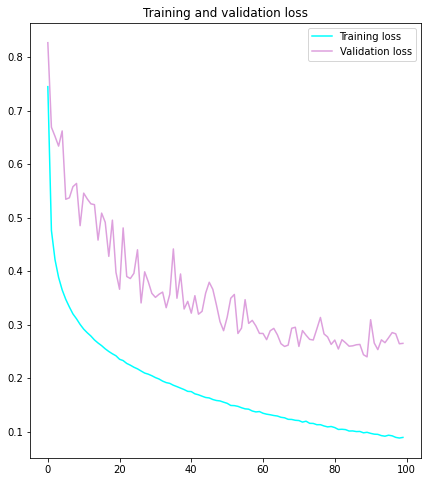

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history_aug.history['accuracy']
val_acc = history_aug.history['val_accuracy']
loss = history_aug.history['loss']
val_loss = history_aug.history['val_loss'] 

epochs = range(len(acc))

plt.figure(figsize = (7,8))

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'plum', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
mat_aug = confusion_matrix(test_y, prediction_test_aug)

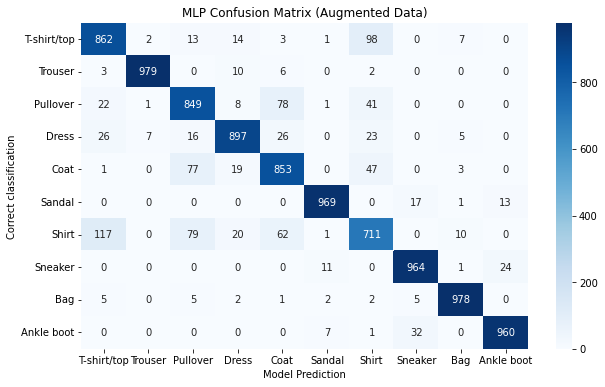

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_aug, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Confusion Matrix (Augmented Data)')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
mat_perc = 100*(mat_aug / mat_aug.sum(axis=1))

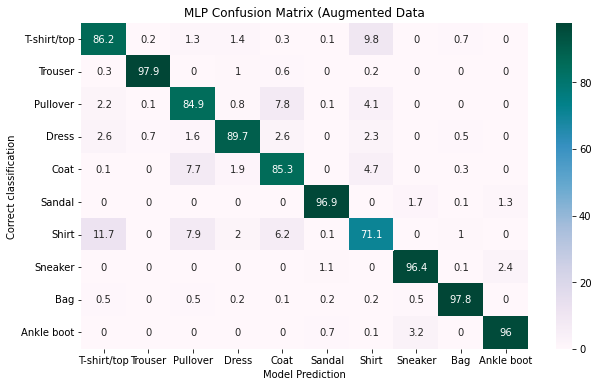

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('MLP Confusion Matrix (Augmented Data)')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_y, prediction_test_aug))

              precision    recall  f1-score   support

           0       0.83      0.86      0.85      1000
           1       0.99      0.98      0.98      1000
           2       0.82      0.85      0.83      1000
           3       0.92      0.90      0.91      1000
           4       0.83      0.85      0.84      1000
           5       0.98      0.97      0.97      1000
           6       0.77      0.71      0.74      1000
           7       0.95      0.96      0.96      1000
           8       0.97      0.98      0.98      1000
           9       0.96      0.96      0.96      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [ ]:
#h_model.save('/content/drive/MyDrive/deep_MLP_')

# CNN

In [ ]:
def build_model2(hp):
    """
    Builds model and sets up hyperparameter space to search.
    
    Parameters
    ----------
    hp : HyperParameter object
        Configures hyperparameters to tune.
        
    Returns
    -------
    model : keras model
        Compiled model with hyperparameters to tune.
    """
    # Initialize sequential API and start building model.
    model = keras.Sequential()
    model.add(keras.layers.Conv2D(
          filters = hp.Choice('conv_1_filter', values=[16, 32]),
          kernel_size=hp.Choice('conv_1_kernel', values = [3,4]),
          kernel_initializer='he_normal',
          padding='same',
          activation='relu',
          input_shape=(28,28,1)))
    model.add(keras.layers.MaxPooling2D((2,2)))

    model.add(keras.layers.Conv2D(
          filters = hp.Choice('conv_2_filter', values=[32, 64]),
          kernel_size=hp.Choice('conv_2_kernel', values = [3,4]),
          padding='same',
          activation='relu',
          ))
    model.add(keras.layers.MaxPooling2D((2,2)))


    model.add(keras.layers.Dropout(hp.Float("dropout_1" + str(i), 0, 0.4, step=0.1)))

    model.add(BatchNormalization())

    model.add(keras.layers.Conv2D(
          filters = hp.Choice('conv_3_filter', values=[ 64, 128]),
          kernel_size=hp.Choice('conv_3_kernel', values = [3,4]),
          padding='same',
          activation='relu',
          ))
    model.add(keras.layers.MaxPooling2D((2,2)))

    model.add(keras.layers.Dropout(hp.Float("dropout_2" + str(i), 0, 0.4, step=0.1)))


    model.add(keras.layers.Flatten())

    model.add(BatchNormalization())

    

    # Number of Units: 128 - 512 with stepsize of 32
    model.add(
            keras.layers.Dense(
                units=hp.Int("units_" + str(i), min_value=128, max_value=512, step=32),
                activation="relu")
            )
        
        # Tune dropout layer with values from 0 - 0.4 with stepsize of 0.1.
    model.add(keras.layers.Dropout(hp.Float("dropout_3" + str(i), 0, 0.4, step=0.1)))
    
    # Add output layer.
    model.add(keras.layers.Dense(units=10, activation="softmax"))
    
    # Tune learning rate for Adam optimizer with values from  0.001, or 0.0001
    hp_learning_rate = hp.Choice("learning_rate", values=[1e-3, 1e-4])
    
    # Define optimizer, loss, and metrics
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                  loss=keras.losses.CategoricalCrossentropy(),
                  metrics=["accuracy"])
    
    return model

In [ ]:
# Instantiate the tuner
tuner2 = kt.BayesianOptimization(build_model2,
                     #Metric which will be used for the hyperparameter tuning
                     objective="val_accuracy", max_trials=5)

In [ ]:
tuner2.search_space_summary(extended=True)

Search space summary
Default search space size: 11
conv_1_filter (Choice)
{'default': 16, 'conditions': [], 'values': [16, 32], 'ordered': True}
conv_1_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
conv_2_filter (Choice)
{'default': 32, 'conditions': [], 'values': [32, 64], 'ordered': True}
conv_2_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
dropout_115 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
conv_3_filter (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128], 'ordered': True}
conv_3_kernel (Choice)
{'default': 3, 'conditions': [], 'values': [3, 4], 'ordered': True}
dropout_215 (Float)
{'default': 0.0, 'conditions': [], 'min_value': 0.0, 'max_value': 0.4, 'step': 0.1, 'sampling': None}
units_15 (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 32, 'sampling': None}
dropout_315 (Float)
{'default': 

In [ ]:
NUM_EPOCHS=20

In [ ]:
#Initializing early-stopping
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

#Tuning
tuner2.search(x_train, train_y_vec, epochs=NUM_EPOCHS, validation_split=0.25, callbacks=[stop_early], verbose=2)

Trial 5 Complete [00h 31m 23s]
val_accuracy: 0.9298666715621948

Best val_accuracy So Far: 0.9298666715621948
Total elapsed time: 02h 45m 55s
INFO:tensorflow:Oracle triggered exit


In [ ]:
print(f"""The number of filters in 1st Convolutional layer is 1""")
print(f"""Kernel size in 1st Convolutional layer is (3,3)""")

print(f"""The number of filters in 2nd Convolutional layer is 32""")
print(f"""Kernel size in 2nd Convolutional layer is (3,3)""")
print(f"""The dropout probability after the 2nd layer Convolutional is 0.2)""")

print(f"""The number of filters in 3rd Convolutional layer is 128""")
print(f"""Kernel size in 3rd Convolutional layer is (3,3)""")
print(f"""The dropout probability after the 3rd layer Convolutional is 0.4)""")

print(f"""The number of nodes in dense layer 2 is 128""")
print(f"""The dropout probability after the dense layer is 0.2""")


print("-------------------------------------------------")
print(f"""learning_rate is 1e-04""")

The number of filters in 1st Convolutional layer is 1
Kernel size in 1st Convolutional layer is (3,3)
The number of filters in 2nd Convolutional layer is 32
Kernel size in 2nd Convolutional layer is (3,3)
The dropout probability after the 2nd layer Convolutional is 0.2)
The number of filters in 3rd Convolutional layer is 128
Kernel size in 3rd Convolutional layer is (3,3)
The dropout probability after the 3rd layer Convolutional is 0.4)
The number of nodes in dense layer 2 is 128
The dropout probability after the dense layer is 0.2
-------------------------------------------------
learning_rate is 1e-04


In [ ]:
# Get the optimal hyperparameters from the results
best_hps=tuner2.get_best_hyperparameters()[0]

# Build model
h_model = tuner2.hypermodel.build(best_hps)

# Train the hypertuned model
history2=h_model.fit(x_train, train_y_vec, epochs=80, validation_split=0.25, callbacks=[stop_early], verbose=2)

Epoch 1/80
1407/1407 - 90s - loss: 0.6534 - accuracy: 0.7711 - val_loss: 0.3824 - val_accuracy: 0.8593 - 90s/epoch - 64ms/step
Epoch 2/80
1407/1407 - 89s - loss: 0.4417 - accuracy: 0.8429 - val_loss: 0.3221 - val_accuracy: 0.8813 - 89s/epoch - 63ms/step
Epoch 3/80
1407/1407 - 89s - loss: 0.3847 - accuracy: 0.8626 - val_loss: 0.2983 - val_accuracy: 0.8935 - 89s/epoch - 64ms/step
Epoch 4/80
1407/1407 - 89s - loss: 0.3482 - accuracy: 0.8733 - val_loss: 0.2802 - val_accuracy: 0.8959 - 89s/epoch - 64ms/step
Epoch 5/80
1407/1407 - 89s - loss: 0.3237 - accuracy: 0.8806 - val_loss: 0.2730 - val_accuracy: 0.8979 - 89s/epoch - 63ms/step
Epoch 6/80
1407/1407 - 89s - loss: 0.3032 - accuracy: 0.8901 - val_loss: 0.2545 - val_accuracy: 0.9049 - 89s/epoch - 63ms/step
Epoch 7/80
1407/1407 - 89s - loss: 0.2860 - accuracy: 0.8965 - val_loss: 0.2466 - val_accuracy: 0.9078 - 89s/epoch - 63ms/step
Epoch 8/80
1407/1407 - 90s - loss: 0.2696 - accuracy: 0.9015 - val_loss: 0.2481 - val_accuracy: 0.9077 - 90s/ep

In [ ]:
#Checking model summary
h_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

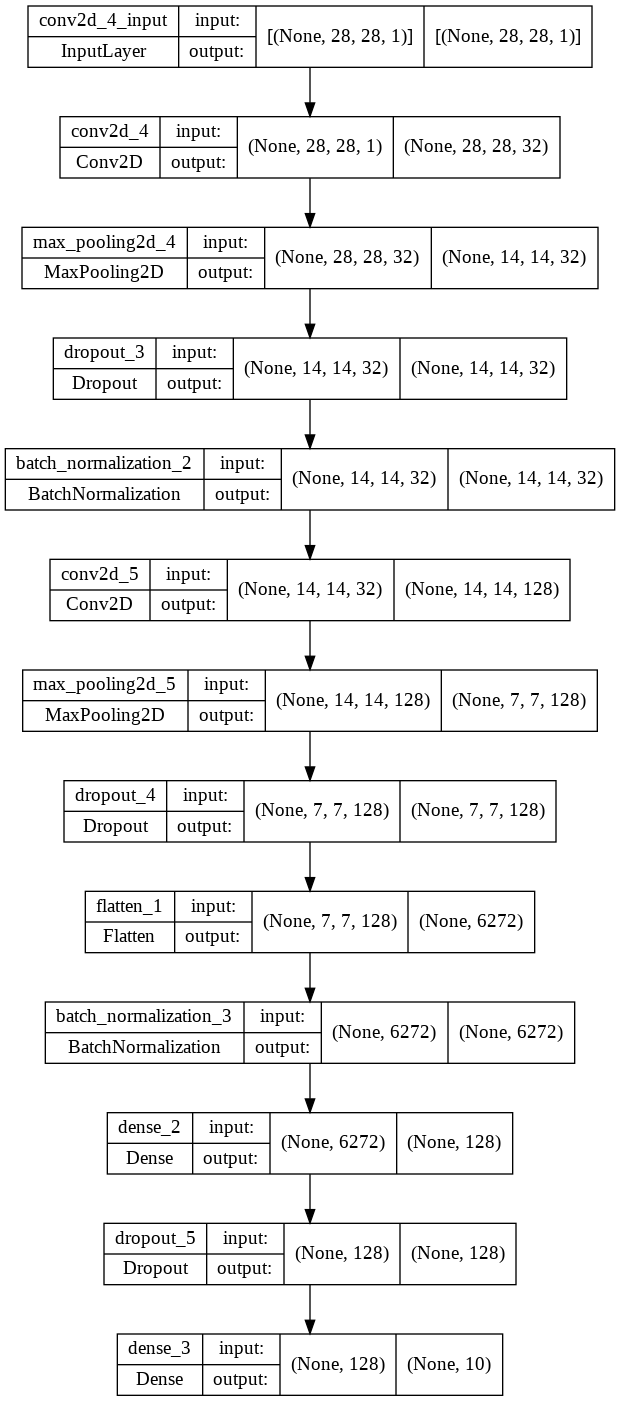

In [ ]:
keras.utils.plot_model(h_model, show_shapes=True)

In [ ]:
predictions_test2 = h_model.predict(x_test)
prediction_test2=[]
for i in range(len(predictions_test2)):
  prediction_test2.append(np.argmax(predictions_test2[i]))

In [ ]:
#Calculating Accuracy score
score2 = accuracy_score(test_y, prediction_test2)

print("Test accuracy-score: {:.2f}% \n".format(score2*100))

Test accuracy-score: 92.63% 



In [ ]:
eval_result2 = h_model.evaluate(x_test, test_y_vec)
print("[test loss, test accuracy]:", eval_result2)

313/313 [==============================] - 5s 15ms/step - loss: 0.2224 - accuracy: 0.9263
[test loss, test accuracy]: [0.2224445343017578, 0.9262999892234802]


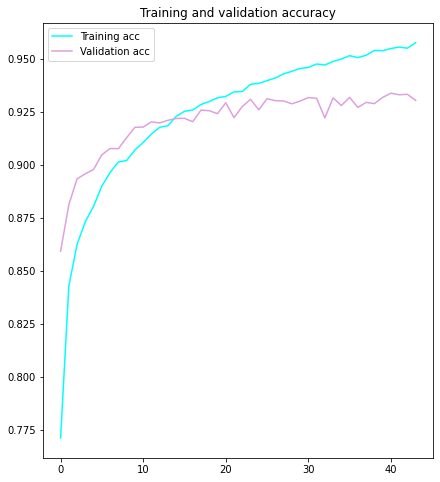

<Figure size 432x288 with 0 Axes>

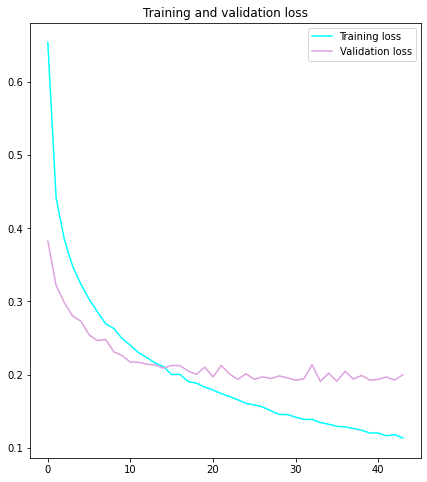

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
loss = history2.history['loss']
val_loss = history2.history['val_loss'] 

epochs = range(len(acc))

plt.figure(figsize = (7,8))

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'plum', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#h_model.save('/content/drive/MyDrive/deep_CNN2')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deep_CNN2/assets


In [ ]:
predictions_test2 = h_model.predict(x_test)
prediction_test2=[]
for i in range(len(predictions_test2)):
  prediction_test2.append(np.argmax(predictions_test2[i]))

In [ ]:
mat2 = confusion_matrix(test_y, prediction_test2)

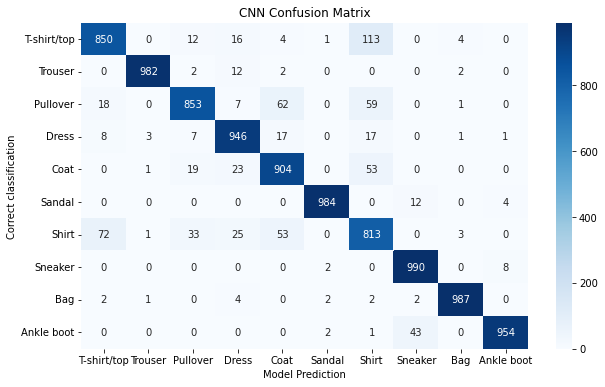

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat2, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
mat_perc2 = 100*(mat2 / mat2.sum(axis=1))

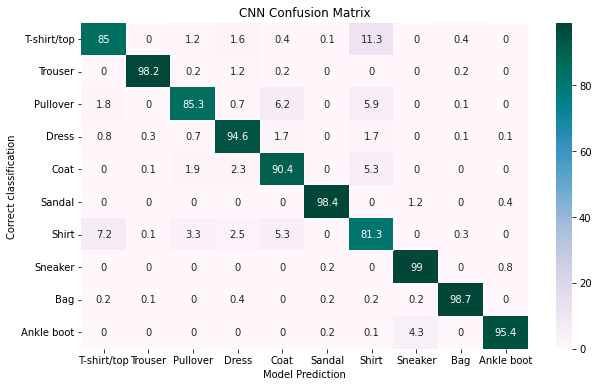

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc2, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_y, prediction_test2))

              precision    recall  f1-score   support

           0       0.89      0.85      0.87      1000
           1       0.99      0.98      0.99      1000
           2       0.92      0.85      0.89      1000
           3       0.92      0.95      0.93      1000
           4       0.87      0.90      0.89      1000
           5       0.99      0.98      0.99      1000
           6       0.77      0.81      0.79      1000
           7       0.95      0.99      0.97      1000
           8       0.99      0.99      0.99      1000
           9       0.99      0.95      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
# from keras.initializers import glorot_uniform  # Or your initializer of choice
# import keras.backend as K

# initial_weights = CNN_model.get_weights()

# backend_name = K.backend()
# if backend_name == 'tensorflow': 
#     k_eval = lambda placeholder: placeholder.eval(session=K.get_session())
# elif backend_name == 'theano': 
#     k_eval = lambda placeholder: placeholder.eval()
# else: 
#     raise ValueError("Unsupported backend")

# new_weights = [K.eval(glorot_uniform()(w.shape)) for w in initial_weights]

# CNN_model.set_weights(new_weights)

In [ ]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=12)
history3=CNN_model.fit(augmented_data_x, augmented_data_y, epochs=100, validation_split=0.25, callbacks=[stop_early], verbose=2)

Epoch 1/100
1688/1688 - 124s - loss: 1.2223 - accuracy: 0.5801 - val_loss: 0.9122 - val_accuracy: 0.6128 - 124s/epoch - 74ms/step
Epoch 2/100
1688/1688 - 116s - loss: 0.5657 - accuracy: 0.7946 - val_loss: 0.6982 - val_accuracy: 0.7201 - 116s/epoch - 69ms/step
Epoch 3/100
1688/1688 - 115s - loss: 0.4503 - accuracy: 0.8376 - val_loss: 0.6187 - val_accuracy: 0.7532 - 115s/epoch - 68ms/step
Epoch 4/100
1688/1688 - 116s - loss: 0.3948 - accuracy: 0.8575 - val_loss: 0.5167 - val_accuracy: 0.8005 - 116s/epoch - 69ms/step
Epoch 5/100
1688/1688 - 115s - loss: 0.3594 - accuracy: 0.8705 - val_loss: 0.4593 - val_accuracy: 0.8252 - 115s/epoch - 68ms/step
Epoch 6/100
1688/1688 - 115s - loss: 0.3370 - accuracy: 0.8795 - val_loss: 0.4863 - val_accuracy: 0.8097 - 115s/epoch - 68ms/step
Epoch 7/100
1688/1688 - 114s - loss: 0.3187 - accuracy: 0.8854 - val_loss: 0.4306 - val_accuracy: 0.8316 - 114s/epoch - 68ms/step
Epoch 8/100
1688/1688 - 114s - loss: 0.3020 - accuracy: 0.8914 - val_loss: 0.4225 - val_ac

In [ ]:
CNN_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 32)        320       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 14, 14, 32)        0         
                                                                 
 batch_normalization_2 (Batc  (None, 14, 14, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 14, 14, 128)       36992     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 7, 7, 128)       

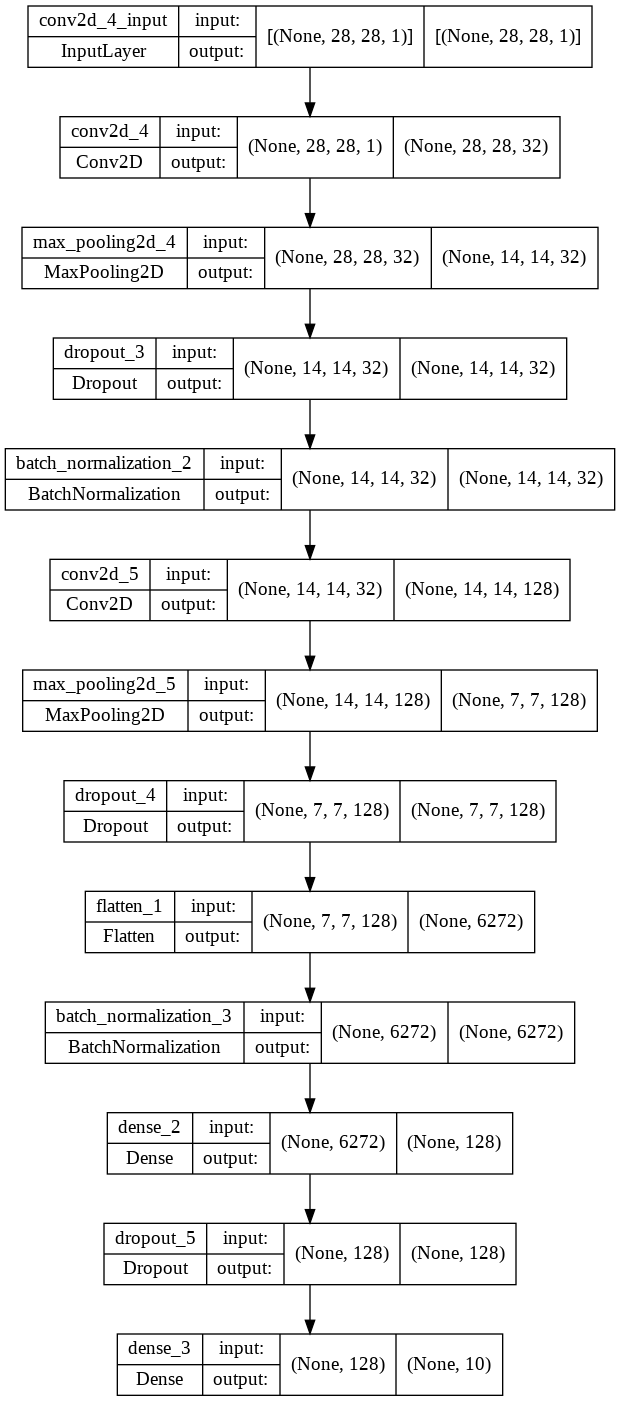

In [ ]:
keras.utils.plot_model(CNN_model, show_shapes=True)

In [ ]:
predictions_test3 = CNN_model.predict(x_test)
prediction_test3=[]
for i in range(len(predictions_test3)):
  prediction_test3.append(np.argmax(predictions_test3[i]))

In [ ]:
#Calculating Accuracy score
score3 = accuracy_score(test_y, prediction_test3)

print("Test accuracy-score: {:.2f}% \n".format(score3*100))

Test accuracy-score: 93.16% 



In [ ]:
eval_result3 = CNN_model.evaluate(x_test, test_y_vec)
print("[test loss, test accuracy]:", eval_result3)

313/313 [==============================] - 6s 17ms/step - loss: 0.2079 - accuracy: 0.9316
[test loss, test accuracy]: [0.20786133408546448, 0.9315999746322632]


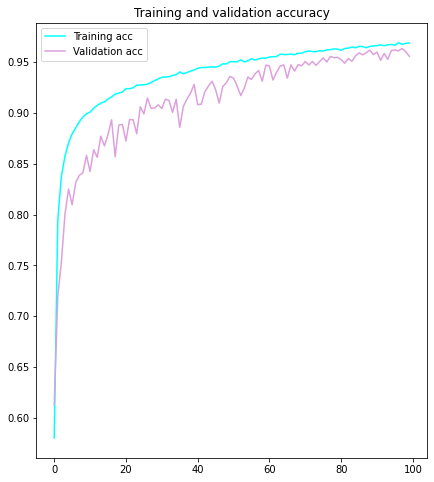

<Figure size 432x288 with 0 Axes>

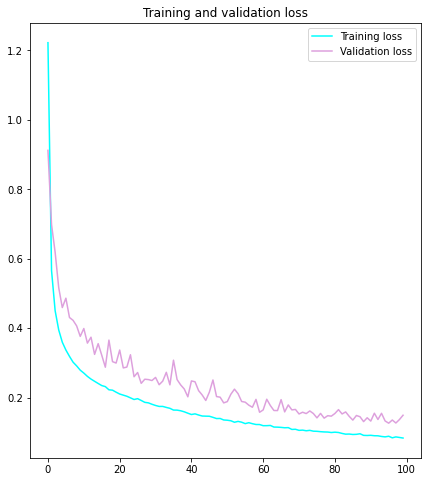

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']
loss = history3.history['loss']
val_loss = history3.history['val_loss'] 

epochs = range(len(acc))

plt.figure(figsize = (7,8))

plt.plot(epochs, acc, 'cyan', label='Training acc')
plt.plot(epochs, val_acc, 'plum', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.figure(figsize = (7,8))

plt.plot(epochs, loss, 'cyan', label='Training loss')
plt.plot(epochs, val_loss, 'plum', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
mat3 = confusion_matrix(test_y, prediction_test3)

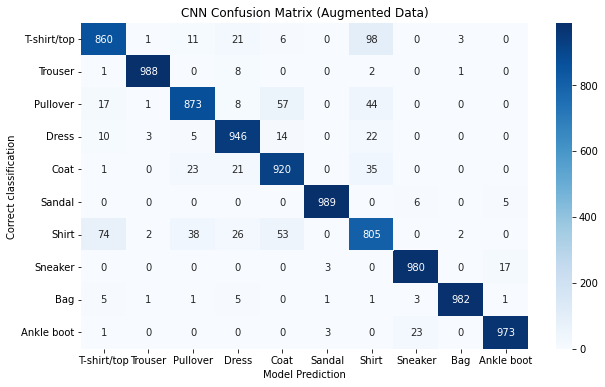

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat3, annot=True, fmt='g', cmap = 'Blues')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix (Augmented Data)')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
mat_perc3 = 100*(mat3 / mat3.sum(axis=1))

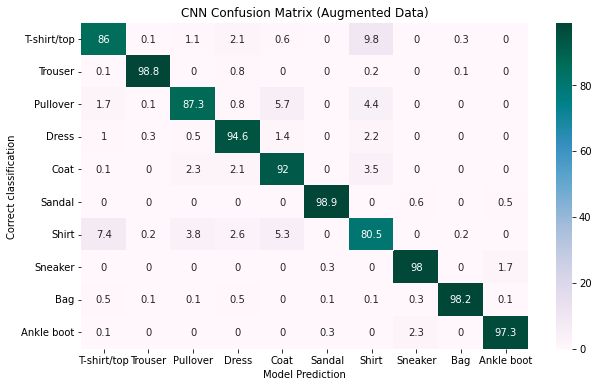

In [ ]:
plt.figure(figsize = (10,6))
ax= plt.subplot()
sns.heatmap(mat_perc3, annot=True, fmt='g', cmap = 'PuBuGn')
ax.set_xlabel('Model Prediction')
ax.set_ylabel('Correct classification'); 
ax.set_title('CNN Confusion Matrix (Augmented Data)')
ax.xaxis.set_ticklabels([label[i] for i in range(0,10)])
ax.yaxis.set_ticklabels([label[i] for i in range(0,10)])
plt.yticks(rotation=0)
plt.show()

In [ ]:
print(classification_report(test_y, prediction_test3))

              precision    recall  f1-score   support

           0       0.89      0.86      0.87      1000
           1       0.99      0.99      0.99      1000
           2       0.92      0.87      0.89      1000
           3       0.91      0.95      0.93      1000
           4       0.88      0.92      0.90      1000
           5       0.99      0.99      0.99      1000
           6       0.80      0.81      0.80      1000
           7       0.97      0.98      0.97      1000
           8       0.99      0.98      0.99      1000
           9       0.98      0.97      0.97      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.93     10000
weighted avg       0.93      0.93      0.93     10000



In [ ]:
#CNN_model.save('/content/drive/MyDrive/deep_CNN_augm')

INFO:tensorflow:Assets written to: /content/drive/MyDrive/deep_CNN_augm/assets


In [ ]:
#model3=tf.keras.models.load_model('/content/drive/MyDrive/deep_CNN_augm')

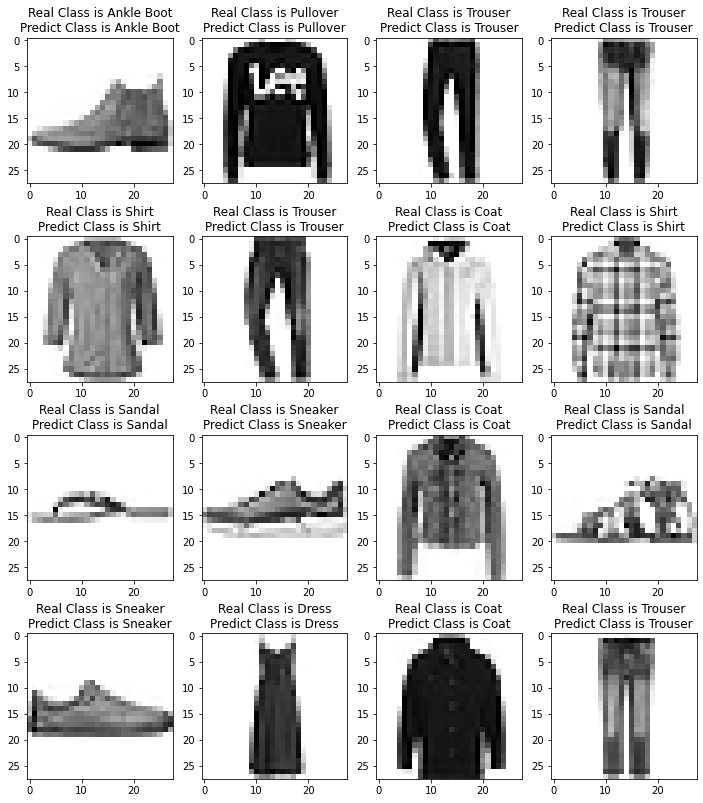

In [ ]:
labels = {0 : "T-shirt/top", 1: "Trouser", 2: "Pullover", 3: "Dress", 4: "Coat",
          5: "Sandal", 6: "Shirt", 7: "Sneaker", 8: "Bag", 9: "Ankle Boot"}

X_test__ = x_test.reshape(x_test.shape[0], 28, 28)

fig, axis = plt.subplots(4, 4, figsize=(12, 14))
for i, ax in enumerate(axis.flat):
    ax.imshow(X_test__[i], cmap='binary')
    ax.set(title = f"Real Class is {labels[test_y[i]]}\nPredict Class is {labels[prediction_test3[i]]}");

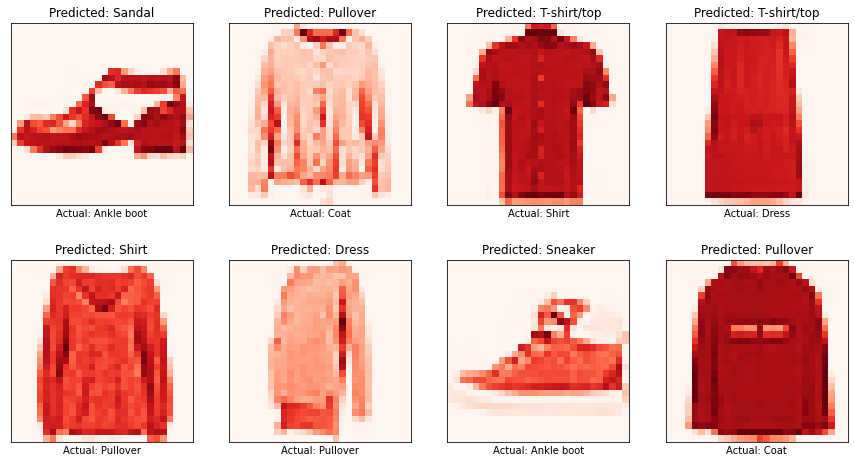

In [ ]:
incorrect = np.nonzero(prediction_test3!=test_y)[0]
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
# Display the first 16 incorrectly classified images from the test data set
plt.figure(figsize=(15, 8))
for j, incorrect in enumerate(incorrect[0:8]):
    plt.subplot(2, 4, j+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[incorrect].reshape(28, 28), cmap="Reds")
    plt.title("Predicted: {}".format(class_names[prediction_test3[incorrect]]))
    plt.xlabel("Actual: {}".format(class_names[test_y[incorrect]]))